(mmm_optimize)=
# MMM Optimization Notebook

In this notebook we begin with the scenario explored in the MMM Example notebook (link to be added). There are 2 channels and we have historical data about the weekly spend on each channel as well as a couple of discrete "events" that will act as control variables.  Our goal is to take a new total budget and return the allocation over the two channels that maximizes the target variable (e.g., sales).

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import scipy

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)
n = df.shape[0]

In [3]:
# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)

In [4]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

In [5]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

In [6]:
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

In [7]:
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

In [8]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]


df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + beta_1 * df["x1_adstock_saturated"]
    + beta_2 * df["x2_adstock_saturated"]
    + df["epsilon"]
)

In [9]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()

data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear
0,2018-04-02,3.984662,0.318580,0.0,0.0,0.0,92
1,2018-04-09,3.762872,0.112388,0.0,0.0,0.0,99
2,2018-04-16,4.466967,0.292400,0.0,0.0,0.0,106
3,2018-04-23,3.864219,0.071399,0.0,0.0,0.0,113
4,2018-04-30,4.441625,0.386745,0.0,0.0,0.0,120


## Part II: Modeling

In [10]:
# trend feature
data["t"] = range(n)

In [11]:
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)
spend_share = total_spend_per_channel / total_spend_per_channel.sum()

In [12]:
# The scale necessary to make a HalfNormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

n_channels = 2

prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()

In [13]:
X = data.drop('y',axis=1)
y = data['y']

In [14]:
mmm = DelayedSaturatedMMM(
    sampler_config = {"progressbar": True},
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)

In [15]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, sigma, gamma_control, gamma_fourier]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Sampling: [alpha, beta_channel, gamma_control, gamma_fourier, intercept, lam, likelihood, sigma]
Sampling: [likelihood]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

## Part III: Optimizing

In [16]:
def obj_function(x, mmm, data, budget, risk_attitude, diversification_bias):
    new_x1_total = x * budget
    new_x2_total = (1 - x) * budget
    old_x1_total = data["x1"].to_numpy().sum()
    old_x2_total = data["x2"].to_numpy().sum()
    new_x1 = (new_x1_total / old_x1_total) * data["x1"]
    new_x2 = (new_x2_total / old_x2_total) * data["x2"]

    # find posterior of parameters
    alpha1 = mmm.fit_result["alpha"].sel(channel="x1").values.ravel()
    alpha2 = mmm.fit_result["alpha"].sel(channel="x2").values.ravel()

    lam1 = mmm.fit_result["lam"].sel(channel="x1").values.ravel()
    lam2 = mmm.fit_result["lam"].sel(channel="x2").values.ravel()

    beta1 = mmm.fit_result["beta_channel"].sel(channel="x1").values.ravel()
    beta2 = mmm.fit_result["beta_channel"].sel(channel="x2").values.ravel()

    # replicate internal transformation of channel spends (using transformer fitted to original data)
    spend_1_transformed, spend_2_transformed = mmm.channel_transformer.transform(
        np.vstack((new_x1, new_x2)).T
    ).T

    # adstock transformation (using estimated parameters)
    x1_adstocked = geometric_adstock(
        x=spend_1_transformed, alpha=alpha1, l_max=8, normalize=True
    )
    x2_adstocked = geometric_adstock(
        x=spend_2_transformed, alpha=alpha2, l_max=8, normalize=True
    )

    # saturation transformation (using estimated parameters)
    x1_ad_saturated = logistic_saturation(x=x1_adstocked, lam=lam1.reshape(-1, 1))
    x2_ad_saturated = logistic_saturation(x=x2_adstocked, lam=lam2.reshape(-1, 1))

    # contribution (using transformer fitted to original data)
    x1_contribution = (
        beta1.reshape(-1, 1) * x1_ad_saturated
    ) / mmm.target_transformer.named_steps["scaler"].scale_.item()

    x2_contribution = (
        beta2.reshape(-1, 1) * x2_ad_saturated
    ) / mmm.target_transformer.named_steps["scaler"].scale_.item()

    contributions = x1_contribution.sum(axis=1) + x2_contribution.sum(axis=1)

    return -pt.mean(contributions**risk_attitude).eval() + diversification_bias * (
        new_x1_total**2 + new_x2_total**2
    )

In [186]:
def get_roas_contribution(x, mmm, data, budget, risk_attitude):
    new_x1_total = x * budget
    new_x2_total = (1 - x) * budget
    old_x1_total = data["x1"].to_numpy().sum()
    old_x2_total = data["x2"].to_numpy().sum()
    new_x1 = (new_x1_total / old_x1_total) * data["x1"]
    new_x2 = (new_x2_total / old_x2_total) * data["x2"]

    # find posterior of parameters
    alpha1 = mmm.fit_result["alpha"].sel(channel="x1").values.ravel()
    alpha2 = mmm.fit_result["alpha"].sel(channel="x2").values.ravel()

    lam1 = mmm.fit_result["lam"].sel(channel="x1").values.ravel()
    lam2 = mmm.fit_result["lam"].sel(channel="x2").values.ravel()

    beta1 = mmm.fit_result["beta_channel"].sel(channel="x1").values.ravel()
    beta2 = mmm.fit_result["beta_channel"].sel(channel="x2").values.ravel()

    # replicate internal transformation of channel spends (using transformer fitted to original data)
    spend_1_transformed, spend_2_transformed = mmm.channel_transformer.transform(
        np.vstack((new_x1, new_x2)).T
    ).T

    # adstock transformation (using estimated parameters)
    x1_adstocked = geometric_adstock(
        x=spend_1_transformed, alpha=alpha1, l_max=8, normalize=True
    )
    x2_adstocked = geometric_adstock(
        x=spend_2_transformed, alpha=alpha2, l_max=8, normalize=True
    )

    # saturation transformation (using estimated parameters)
    x1_ad_saturated = logistic_saturation(x=x1_adstocked, lam=lam1.reshape(-1, 1))
    x2_ad_saturated = logistic_saturation(x=x2_adstocked, lam=lam2.reshape(-1, 1))

    # contribution (using transformer fitted to original data)
    x1_contribution = (
        beta1.reshape(-1, 1) * x1_ad_saturated
    ) / mmm.target_transformer.named_steps["scaler"].scale_.item()

    x2_contribution = (
        beta2.reshape(-1, 1) * x2_ad_saturated
    ) / mmm.target_transformer.named_steps["scaler"].scale_.item()

    # evaluate convert tensors
    x1_contribution = x1_contribution.eval()
    x2_contribution = x2_contribution.eval()

    # ROAS and sales
    return (
        (x1_contribution.sum(axis=1) ** risk_attitude)
        / (new_x1_total**risk_attitude),
        (x2_contribution.sum(axis=1) ** risk_attitude)
        / (new_x2_total**risk_attitude),
        x1_contribution.sum(axis=1) ** risk_attitude,
        x2_contribution.sum(axis=1) ** risk_attitude,
    )

In [104]:
# optimize for new total budgets

orig_budget = df[["x1", "x2"]].values.sum()
new_budgets = np.linspace(orig_budget * 0.75, orig_budget * 1.25, num = 5)
risk_attitude = 1
diversification_bias = 0

opt_solutions = list()
    
for budget in new_budgets:
    print(f"Optimizing budget = {budget:.2f}")
    # optimize objective function
    solution = scipy.optimize.minimize(
        fun = obj_function,
        x0 = [.5],
        args = (mmm, df, budget, risk_attitude, diversification_bias),
        bounds = scipy.optimize.Bounds(lb = 0, ub = 1)
    )

    # store optimized parameters
    opt_solutions.append(solution)

Optimizing budget = 63.22.
Optimizing budget = 73.76.
Optimizing budget = 84.30.
Optimizing budget = 94.83.
Optimizing budget = 105.37.


In [109]:
prop = {
    "Budget": new_budgets,
    "x1_prop": [opt_solutions[i].x[0] for i in range(len(opt_solutions))],
}
prop_budgets = pd.DataFrame(prop)
prop_long_budgets = (
    pd.melt(prop_budgets, id_vars="Budget", value_vars=["x1_prop"])
    .drop(columns=["variable"])
    .rename(columns={"value": "x1_prop"})
)

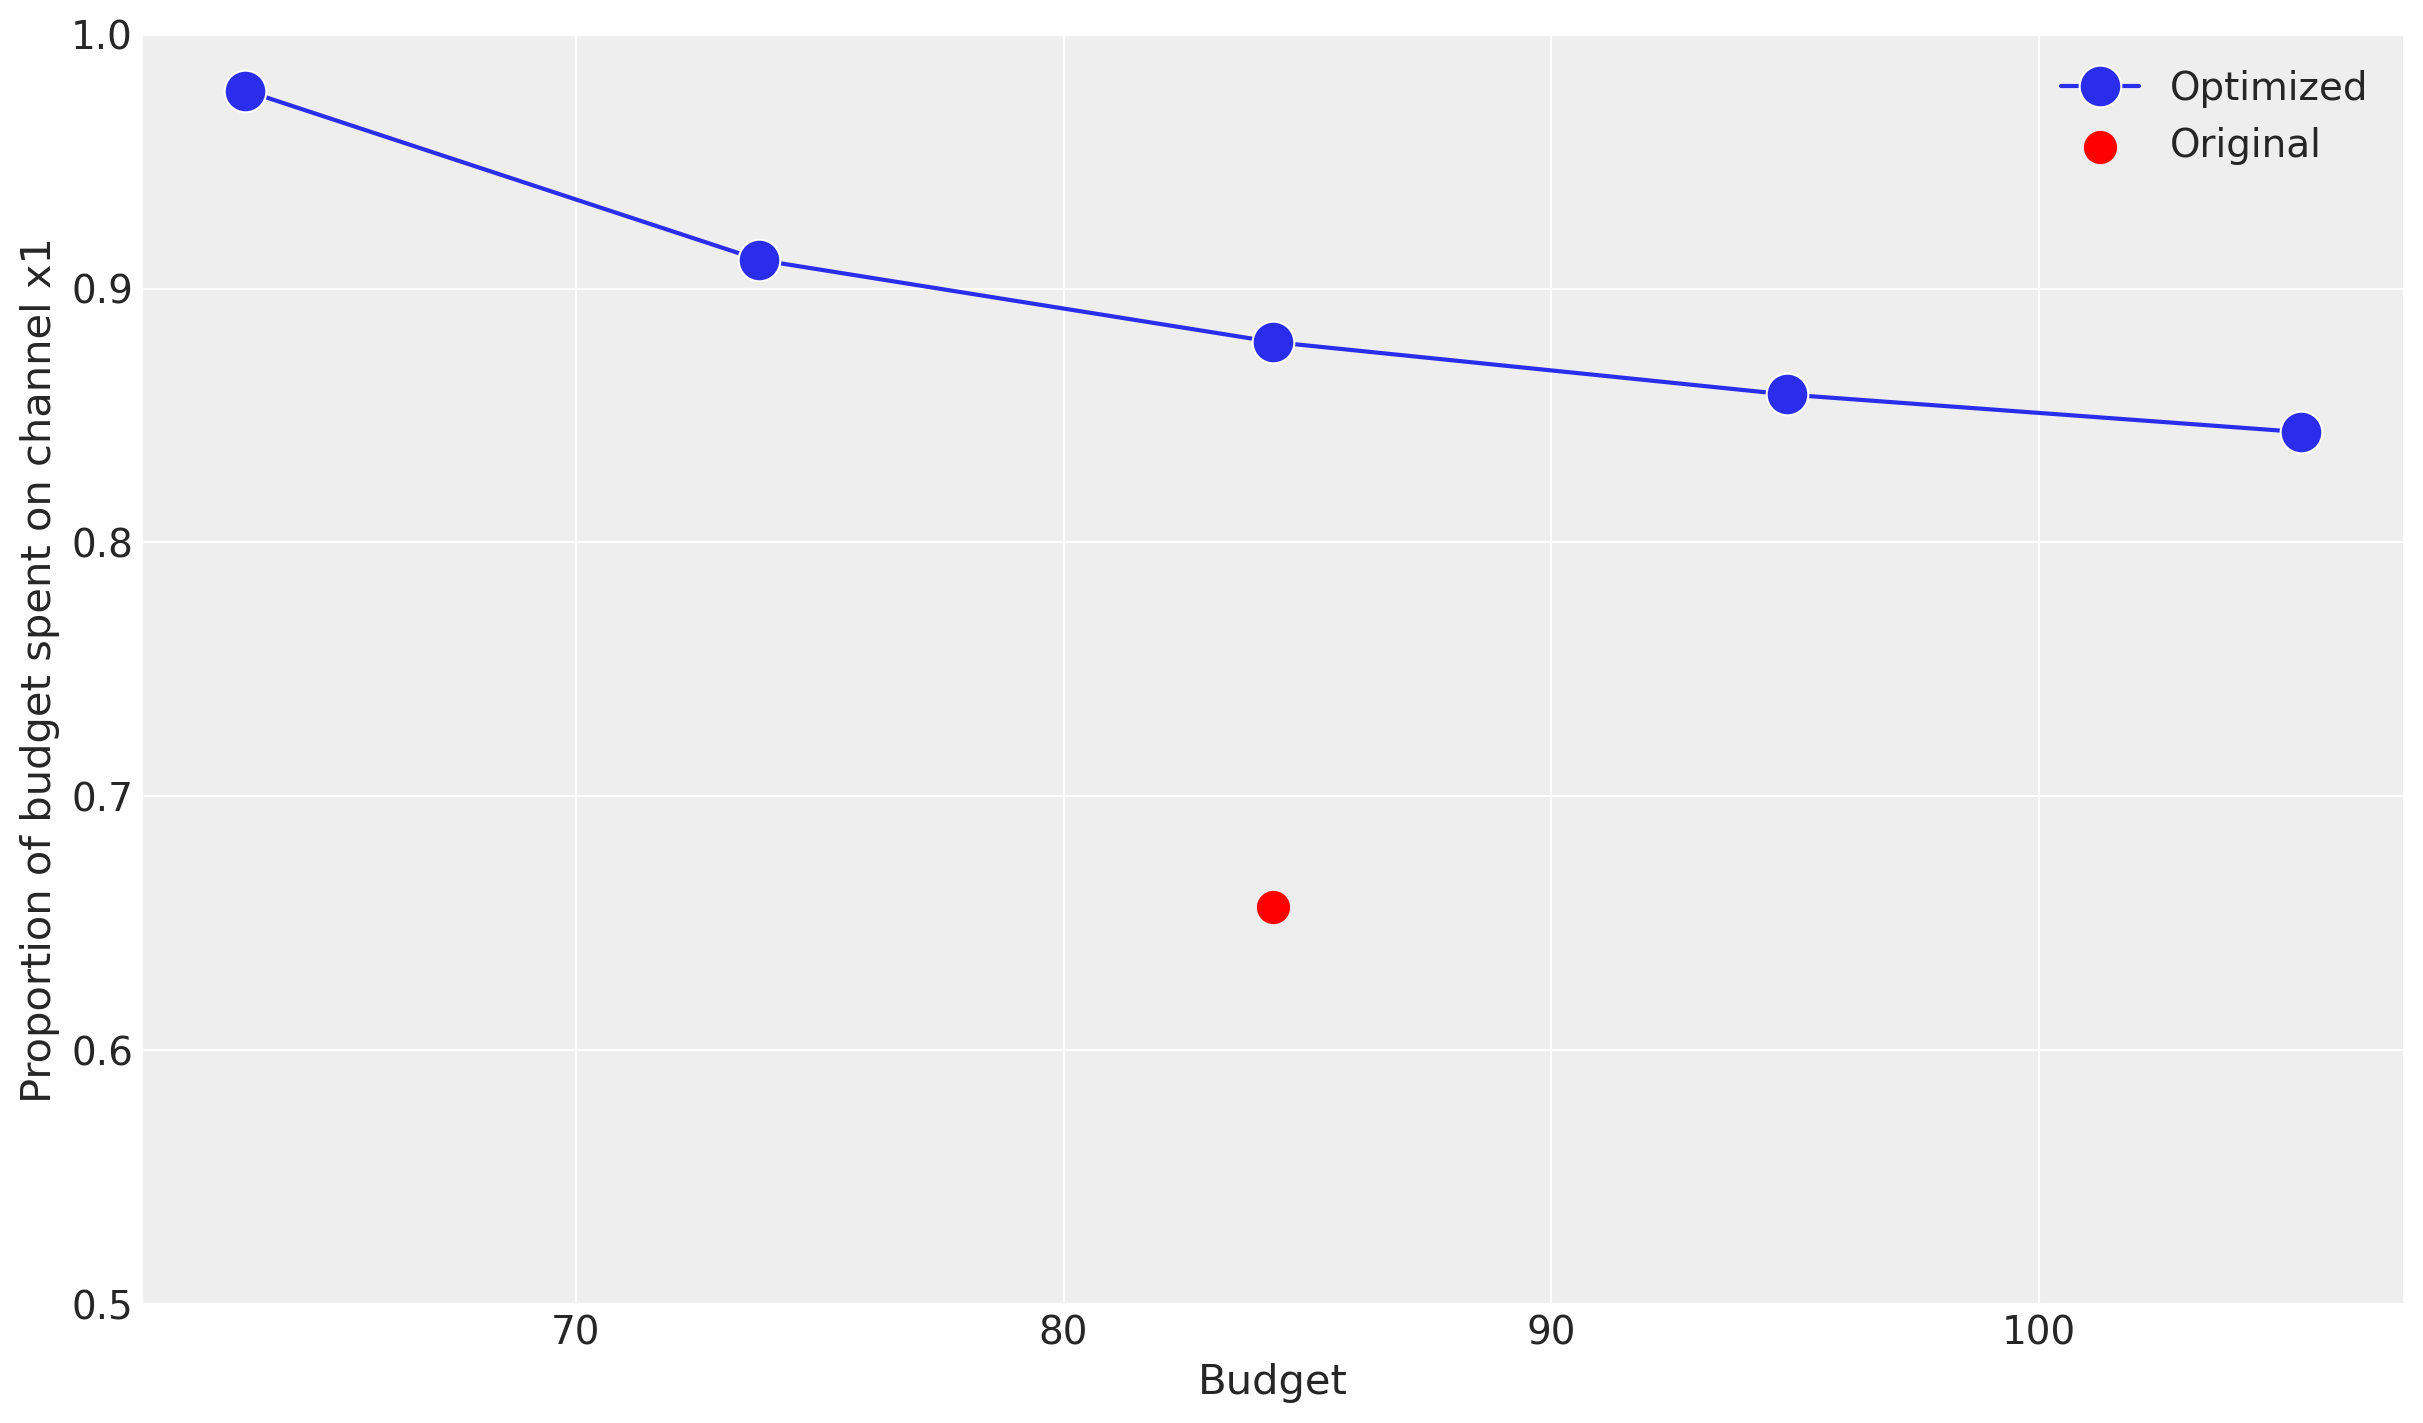

In [140]:
sns.lineplot(
    x="Budget",
    y="x1_prop",
    marker="o",
    markersize=15,
    data=prop_long_budgets,
    label="Optimized",
)
plt.scatter(
    orig_budget,
    data["x1"].to_numpy().sum() / orig_budget,
    c="r",
    s=120,
    label="Original",
)
plt.xlabel("Budget")
plt.ylabel("Proportion of budget spent on channel x1")
plt.legend()
plt.ylim((0.5, 1.0));

In [188]:
list_of_dfs = []
for i, budget in enumerate(new_budgets):
    roas1, roas2, contribution1, contribution2 = get_roas_contribution(
        opt_solutions[i].x, mmm, df, budget, risk_attitude
    )
    d = {
        "budget": np.repeat(np.round(budget), len(contribution1)),
        "contribution1": contribution1,
        "contribution2": contribution2,
    }
    # d = {"budget": np.repeat(np.round(budget), len(contribution1)), "roas1": roas1, "roas2": roas2}
    list_of_dfs += [pd.DataFrame(data=d)]

contributions = pd.concat(list_of_dfs).reset_index(drop=True)
contributions["id"] = contributions.index
contributions = (
    pd.wide_to_long(contributions, stubnames="contribution", i="id", j="channel")
    .reset_index()
    .drop(columns="id")
)

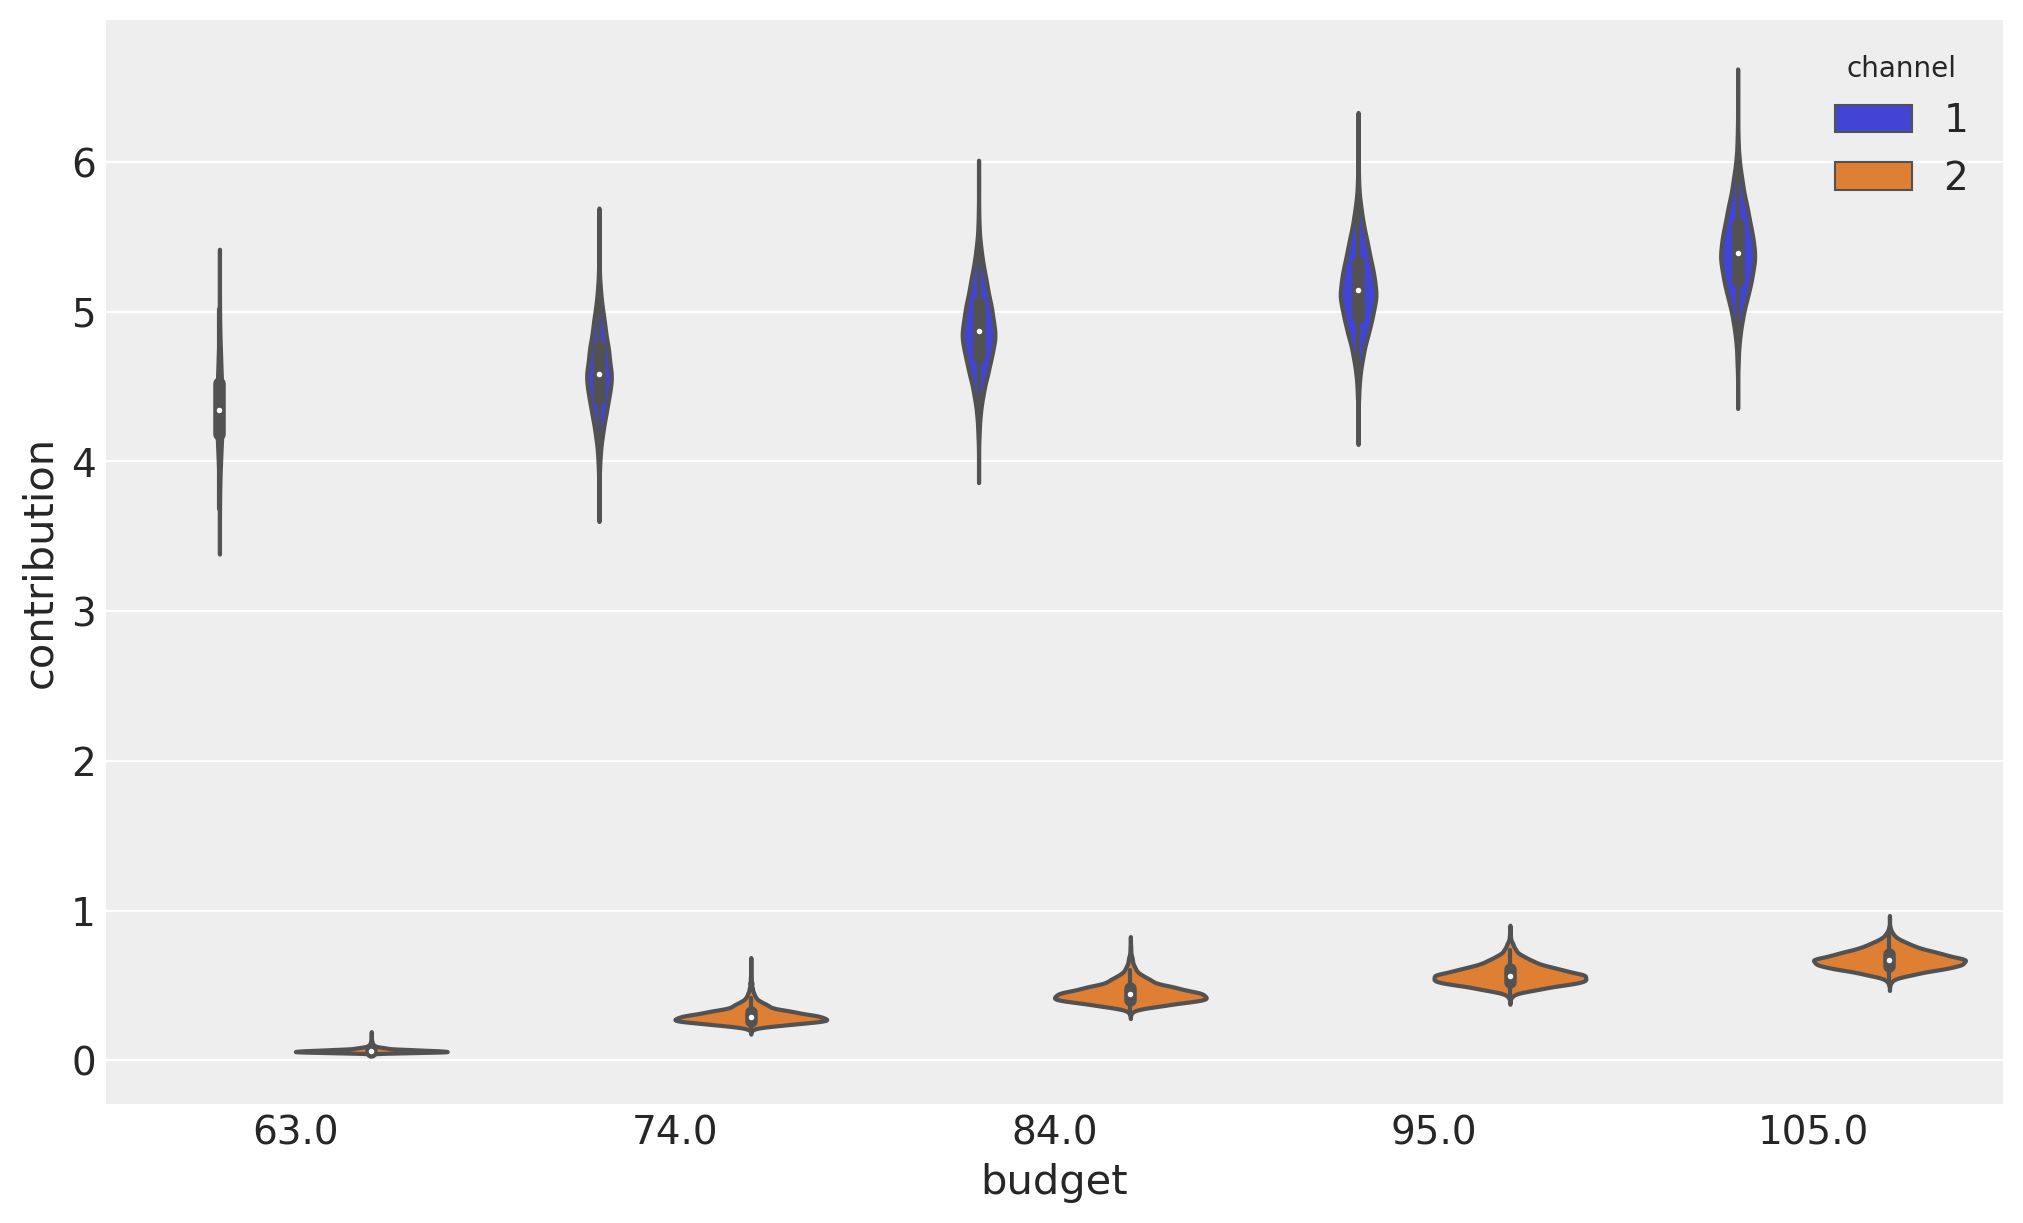

In [190]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.violinplot(
    x="budget",
    y="contribution",
    hue="channel",
    #linewidth = 0.6,
    data=contributions
) 